# 3. GPT моделін іске асыру
# 3. Реализация GPT модели 

In [3]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.5.1
tiktoken version: 0.8.0


- Бұл тарауда біз GPT-ге ұқсас LLM  құрамыз; келесі тарау осы LLM-ді оқытуға арналады.
***
- В этой главе мы реализуем архитектуру LLM, подобную GPT; следующая глава будет посвящена обучению этой LLM.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="1000px">

## 3.1  LLM моделінің негізін құрастыру
## 3.1  Создание ядро LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="1000px">

* Алдыңғы тарауларда біз көрнекілікті жеңілдету және бір бетке сыйғызу үшін токеннің кіріс пен шығыс деректеріне арналған шағын ендірме өлшемдерін қолдандық.
* Бұл тарауда біз шағын GPT-2 моделіне ұқсас ендірме (embedding) және модель өлшемдерін қарастырамыз.
* 5-тарауда біз модельды алдын ала оқытылған салмақтармен  қалай жүктеу болатыны көрсетіледі, ол 345, 762 және 1542 миллион параметрлік модель өлшемдерімен үйлесімді болады.
***

* В предыдущих главах мы использовали небольшие размерности встраивания (эмбеддингов) для входных и выходных токенов для наглядности, чтобы они помещались на одной странице.
* В этой главе мы рассмотрим размеры встраивания и модели, аналогичные небольшой модели GPT-2.
* В Главе 6 будет показано, как загружать предварительно обученные веса в нашу реализацию, которая будет совместима с моделями размером в 345, 762 и 1542 миллиона параметров.

- Төменде 124 миллион параметрлі GPT-2 моделінің конфигурация мәліметтері:
***
- Ниже Детали конфигурации для модели GPT-2 со 124 миллионами параметров:

In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

* `"vocab_size"` 1-тарауда талқыланған BPE токенизаторы қолдайтын 50 257 сөзден тұратын сөздік қорының өлшемін білдіреді.
* `"context_length"` 1-тарауда қарастырылған позициялық ендірмелер арқылы қамтамасыз етілетін модельдің максималды кіріс токендерінің санын білдіреді.
* `"emb_dim"` — бұл токендік кірістерге арналған ендірме (embeding) өлшемі, ол әрбір кіріс токенін 768 өлшемді векторға айналдырады.
* `"n_heads"` — 2-тарауда іске асырылған көпбасты назар аудару механизміндегі назар аудару бастарының саны.
* `"n_layers"` — бұл модель ішіндегі трансформер блоктарының саны, оны біз алдағы бөлімдерде іске асырамыз.
* `"drop_rate"` — бұл 2-тарауда талқыланған dropout механизмінің қарқындылығы; 0.1 мәні артық үйренуді азайту үшін оқыту кезінде жасырын бірліктердің 10%-ын алып тастауды білдіреді.
* `"qkv_bias"` сұрау (Q), кілт (K) және мән (V) тензорларын есептеу кезінде көпбасты назар аудару механизміндегі (2-тараудан) `Linear` қабаттарында ығысу векторының болуын анықтайды; біз бұл опцияны өшіреміз, бұл заманауи LLM-дерде стандартты тәжірибе болып табылады; дегенмен, біз бұған 4-тарауда OpenAI-дың алдын ала оқытылған GPT-2 салмақтарын біздің қайта іске асыруымызға жүктеген кезде қайта ораламыз.
***
* `"vocab_size"` указывает на размер словаря в 50 257 слов, который поддерживается токенизатором BPE, рассмотренным в Главе 1.
* `"context_length"` представляет максимальное количество входных токенов для модели, которое обеспечивается позиционными встраиваниями (эмбеддингами), рассмотренными в Главе 1.
* `"emb_dim"` — это размер встраивания (эмбеддинга) для входных токенов, преобразующий каждый входной токен в 768-мерный вектор.
* `"n_heads"` — это количество голов внимания в механизме многоголового внимания, реализованном в Главе 2.
* `"n_layers"` — это количество блоков трансформера в модели, которые мы реализуем в следующих разделах.
* `"drop_rate"` — это интенсивность механизма dropout, рассмотренного в Главе 2; 0.1 означает исключение 10% скрытых юнитов во время обучения для борьбы с переобучением.
* `"qkv_bias"` определяет, должны ли слои `Linear` в механизме многоголового внимания (из Главы 3) включать вектор смещения при вычислении тензоров запроса (Q), ключа (K) и значения (V); мы отключим эту опцию, что является стандартной практикой в современных LLM; однако мы вернемся к этому позже, когда будем загружать предварительно обученные веса GPT-2 от OpenAI в нашу реализацию в главе 4.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="1000px">

In [5]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="1000px">

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## 3.2 Активацияларды `қабат нормализациясы` арқылы нормализациясын жасау (layer normalization)
## 3.2 Нормализация активаций с помощью `послойной нормализации` (layer normalization)


* `LayerNorm` деп те аталатын қабат нормализациясы, нейрондық желі қабатындағы активациялардың орташа мәнін 0-ге, ал дисперсиясын 1-ге келтіреді.
* Бұл жаттықтыруды тұрақтандырады және тиімді салмақтарға тезірек жақындауға мүмкіндік береді.
* Қабат нормализациясы трансформер блогының ішіндегі (оны біз кейінірек іске асырамыз) көпбасты зейін модуліне дейін және одан кейін қолданылады. Сонымен қатар, ол соңғы шығыс қабатының алдында да қолданылады.
***
* Послойная нормализация, также известная как LayerNorm, центрирует активации слоя нейронной сети так, чтобы их среднее значение было равно 0, а дисперсия — 1.
* Это стабилизирует обучение и обеспечивает более быструю сходимость к эффективным весам.
* Послойная нормализация применяется как до, так и после модуля многоголового внимания (multi-head attention) внутри блока трансформера (который мы реализуем позже); она также применяется перед последним выходным слоем.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="1000px">

- Қабат нормализацияның қалай жұмыс істейтінін көру үшін, кішігірім кіріс үлгісін қарапайым нейрондық желі қабатынан өткізіп көрейік:
***
- Давайте посмотрим, как работает послойная нормализация, пропустив небольшой входной образец через простой слой нейронной сети:

In [8]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [9]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

- Жоғарыдағы 2 кірістің әрқайсысы үшін орташа мәні мен дисперсиясын есептейік:
- Давайте вычислим среднее значение и дисперсию для каждого из 2 входов выше:

In [10]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- Нормализациялау екі кірістің (қатардың) әрқайсысына тәуелсіз түрде қолданылады;  `dim=-1` параметры  баған  бойынша есептеу үшін қолданады. (қатар бойынша емес)
***
- Нормализация применяется к каждому из двух входов (строк) независимо; `dim=-1` указывает, что вычисления производятся по столбцам, а не по строкам.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="1000px">

- Орташа мәнді алып, дисперсияның квадрат түбіріне (стандартты ауытқуға) бөлсек, кірістер баған (белгі) өлшемі бойынша орташа мәні 0, ал дисперсиясы 1 болатындай етіп центрленеді:
***
- Вычитание среднего значения и деление на квадратный корень из дисперсии (стандартное отклонение) центрирует входы так, чтобы их среднее значение стало равным 0, а дисперсия — 1 по измерению столбцов (признаков):

In [11]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Әрбір кіріс 0-ге центрленген және дисперсиясы 1-ге тең; оқылуын жақсарту үшін PyTorch-тың ғылыми нотациясын өшіруге болады:
***
* Каждый вход центрирован на 0 и имеет единичную дисперсию 1; для улучшения читаемости можно отключить научную нотацию в PyTorch:

In [12]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Жоғарыда біз әрбір кірісті нормаладық.
- Енді осы идеяны пайдалана отырып, `LayerNorm` класын іске асыра аламыз:
***
- Выше мы нормализовали признаки каждого входа.
- Теперь, используя эту же идею, мы можем реализовать класс `LayerNorm`:

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Масштабтау және ығыстыру**
* Орташа мәнді алып, дисперсияға бөлу арқылы нормалауды орындаумен қатар, біз екі оқытылатын параметрді қостық: `scale` (масштабтау) және `shift` (ығыстыру) параметрі. LLM жаттығу кезінде өзгеретін параметрлер
* Бастапқы `scale` (1-ге көбейту) және `shift` (0-ді қосу) мәндері ешқандай әсер етпейді.
* Бұл  ең қолайлы масштабтау мен ығыстыруды үйренуге мүмкіндік береді.
* Сондай-ақ, дисперсияның квадрат түбірін есептемес бұрын, біз шағын `eps` мәнін қосатынымызды ескеріңіз. Бұл дисперсия 0-ге тең болған жағдайда нөлге бөлу қателерін болдырмау үшін жасалады.
***Ығысқан дисперсия***
* Жоғарыдағы дисперсияны есептеуде `unbiased=False` параметрін орнату дисперсияны есептеу үшін $\frac{\sum_i (x_i - \bar{x})^2}{n}$ формуласын пайдалануды білдіреді, мұндағы `n` — таңдау көлемі (бұл жағдайда, қатарлар немесе бағандар саны).
* Ендірме өлшемі өте үлкен болатын LLM үшін `n` мен `n-1` арасындағы айырмашылық мардымсыз.
* Алайда, GPT-2 нормализацияя қабаттарында ығысқан дисперсия арқылы жаттықтырылған, сондықтан біз бұл параметрді кейінгі тарауларда жүктейтін алдын ала оқытылған салмақтармен үйлесімділік үшін қостық.
* Енді `LayerNorm`-ды іс жүзінде қолданып көрейік:
***
***Масштабирование и сдвиг***
- Обратите внимание, что в дополнение к выполнению нормализации путём вычитания среднего и деления на дисперсию, мы добавили два обучаемых параметра: `scale` (масштаб) и `shift` (сдвиг).
- Начальные значения `scale` (умножение на 1) и `shift` (сложение с 0) не оказывают никакого эффекта. Однако `scale` и `shift` являются обучаемыми параметрами, которые LLM (Большая языковая модель) автоматически настраивает во время обучения.
- Это позволяет модели изучить подходящие масштабирование и сдвиг, которые наилучшим образом соответствуют обрабатываемым данным.
- Заметим также, что мы добавляем небольшое значение `eps` перед вычислением квадратного корня из дисперсии. Это делается для того, чтобы избежать ошибок деления на ноль, если дисперсия равна 0.

***Смещённая дисперсия***

- В приведённом выше расчёте дисперсии установка `unbiased=False` означает использование формулы $\frac{\sum_i (x_i - \bar{x})^2}{n}$ для вычисления дисперсии, где n — размер выборки (здесь — количество признаков или столбцов). 
- Для LLM, где размерность вложения n очень велика, разница между использованием n и n-1 незначительна.
- Однако GPT-2 обучалась со смещённой дисперсией в слоях нормализации, поэтому мы также приняли эту настройку из соображений совместимости с предобученными весами, которые мы будем загружать в следующих главах.
- Теперь давайте опробуем LayerNorm на практике:

In [14]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [15]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="1000px">

## 3.3 GELU активациясы бар feed-forward желісін іске асыру
## 3.3 Реализация feed-forward сети с активацией GELU

- Бұл бөлімде біз LLM-дерде (Ауқымды тіл модельдерде) трансформатор блогының бөлігі ретінде қолданылатын шағын нейрондық  субмодулін іске асырамыз.
- Алдымен активациясы функциясынан бастаймыз.
- Тереңд оқытуда **ReLU** (Rectified Linear Unit) активация функциялары қарапайымдылығы мен әртүрлі нейрондық желі архитектураларындағы тиімділігіне байланысты жиі қолданылады.
- LLM-дерде дәстүрлі **ReLU**-дан басқа активация функцияларының түрлі типтері қолданылады; олардың екі жарқын мысалы – **GELU** (Gaussian Error Linear Unit) және **SwiGLU** (Swish-Gated Linear Unit).
- `ReLU` (Rectified Linear Unit) — қарапайым, өткір функция. Егер кіріс теріс болса, шығыс нөлге тең болады. Егер оң болса, шығыс кірістің өзіне тең. Бұл нөл нүктесінде функция дифференциалданбайтын қатты «бұрыш» жасайды. Оны қарапайым қосу/өшіру қосқышы ретінде елестетуге болады.

- `GELU` (Gaussian Error Linear Unit) және `SwiGLU` (Swish-Gated Linear Unit) — тегіс функциялар. Олар нөл айналасында біртіндеп иіледі, яғни олардың барлық жерде градиенті болады. Бұл тегістік оқыту процесіне (градиенттік түсу) тиімдірек жұмыс істеуге көмектеседі, бұл тұрақты оқытуға және жиі жақсырақ нәтижелерге әкеледі. Олар ақпараттың неғұрлым дәл ағынын қамтамасыз ететін жарық реттегішіне ұқсайды.
***
- В этом разделе мы реализуем небольшой подмодуль нейронной сети, который используется как часть блока трансформера в LLM (больших языковых моделях).
- Начнём с функции активации.
- В глубоком обучении функции активации **ReLU** (Rectified Linear Unit) часто используются благодаря их простоте и эффективности в различных архитектурах нейронных сетей.
- В LLM, помимо традиционной **ReLU**, используются и другие типы функций активации; два ярких примера — это **GELU** (Gaussian Error Linear Unit) и **SwiGLU** (Swish-Gated Linear Unit).
- `ReLU` (Rectified Linear Unit) — это простая, резкая функция. Если входное значение отрицательное, выход равен нулю. Если оно положительное, выход равен самому входному значению. Это создает жёсткий «угол» в точке ноль, где функция недифференцируема. Думайте о ней как о простом переключателе вкл/выкл.
- `GELU` (Gaussian Error Linear Unit) и `SwiGLU` (Swish-Gated Linear Unit) — это плавные функции. Они мягко изгибаются вокруг нуля, что означает, что у них везде есть градиент. Эта плавность помогает процессу обучения (градиентному спуску) работать более эффективно, что приводит к более стабильному обучению и зачастую к лучшим результатам. Они больше похожи на диммер (регулятор яркости), который позволяет более тонко управлять потоком информации.

In [16]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

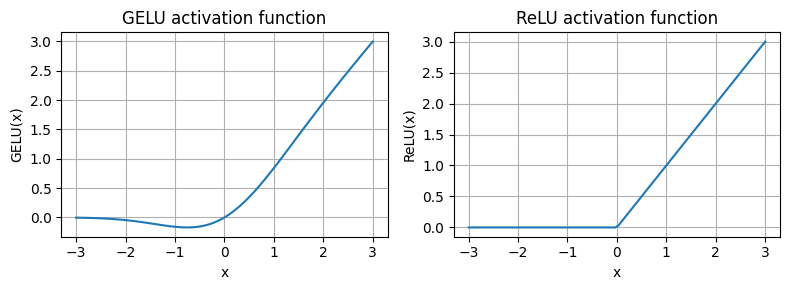

In [17]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

* Көріп отырғанымыздай, **ReLU** – бұл бөлікті-сызықтық функция: егер оған берілген сан оң болса, ол сол санның өзін шығарады, ал теріс болса, нөлді шығарады.
* **GELU** – бұл **ReLU**-ға ұқсайтын, бірақ тегіс әрі сызықтық емес функция. Оның айырмашылығы, теріс сандар үшін градиенті нөлге тең емес (тек -0.75-ке жақын нүктеде ғана нөлге жуықтайды).
* Енді, кейінірек LLM-нің трансформер блогында қолданылатын `FeedForward` атты шағын нейрондық желі модулін жасап көрейік:
***
* Как мы видим, **ReLU** — это кусочно-линейная функция, которая просто возвращает входное число, если оно положительное, а в противном случае возвращает ноль.
* **GELU** — это плавная, нелинейная функция, похожая на **ReLU**, но имеющая ненулевой градиент для отрицательных значений (за исключением точки примерно -0.75).
* Далее, давайте реализуем небольшой модуль нейронной сети `FeedForward`, который мы позже будем использовать в блоке трансформера LLM:

In [18]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="1000px">

In [20]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="1000px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="1000px">

# 3.4 Төте байланыстарды қосу
# 3.4  Добавление обходных соединений


* Өткізіп жібергіш (skip) немесе қалдық (residual) қосылымдар деп аталатын қысқа жол (shortcut) қосылымдарының тұжырымдамасы туралы айтайық.
* Бастапқыда қысқа жол қосылымдары компьютерлік көруге арналған терең желілерде (қалдық желілер) жоғалатын градиент мәселесін жеңілдету үшін ұсынылды.
* Қысқа жол қосылымы градиенттің желі арқылы өтуі үшін баламалы қысқа жолды жасайды.
* Ол бір қабаттың шығысын кейінгі қабаттың шығысына қосу арқылы қол жеткізіледі, бұл кезде әдетте олардың арасындағы бір немесе бірнеше қабат өткізіліп жіберіледі.
* Бұл идеяны шағын мысал желісі арқылы көрсетейік:
***
* Далее, давайте поговорим о концепции обходных соединений, также называемых пропускающими (skip) или остаточными (residual) соединениями.
* Изначально обходные соединения были предложены в глубоких сетях для компьютерного зрения (остаточных сетях), чтобы решить проблему затухающего градиента.
* Обходное соединение создает альтернативный, более короткий путь для прохождения градиента через сеть.
* Это достигается путем сложения выхода одного слоя с выходом последующего слоя, при этом обычно пропускается один или несколько слоев между ними.
* Проиллюстрируем эту идею на примере небольшой сети:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="1000px">

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

* Алдымен градиент мәндерін **қысқа жол қосылымдарынсыз** (`shortcut`) шығарып көрейік:
    
* Сначала давайте выведем значения градиента **без обходных соединений** (shortcut):

In [22]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


* Енді градиент мәндерін **қысқа жол қосылымдарымен** шығарып көрейік:
***
* Далее, давайте выведем значения градиента **с** обходными соединениями:

In [23]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


* Жоғарыдағы нәтижеден көріп отырғанымыздай, **қысқа жол қосылымдары** (shortcuts) алғашқы қабаттардағы (`layer.0`-ға қарай) градиенттердің жойылып кетуін болдырмайды.
* Трансформер блогын іске асырған кезде біз осы **қысқа жол қосылымы** (shortcuts) тұжырымдамасын келесі кезекте қолданамыз.
***
* Как мы видим из вывода выше, **обходные соединения** (shortcuts) предотвращают затухание градиентов в ранних слоях (в направлении `layer.0`).
* Мы будем использовать эту концепцию **обходного соединения** (shortcuts) далее, когда будем реализовывать блок трансформера.

## 3.5 Трансформер блогында **зейін** және **сызықтық қабаттарды** байланыстыру
***
## 3.5 Соединение **внимания** и **линейных слоев** в блоке трансформера

* Бұл бөлімде жоғарыда қарастырылған құрылымдарды **трансформер блогына** біріктіреміз.
* Трансформер блогы  
    * 1. **Зейін модулінен** (Multi-Head Self-Attention);
    * 2. **Сызықтық нейрондық желіден** (Linear layers), 
    * 3. **Feed Forward желіден**
    * 4. **Dropout**
    * 5. **Қысқа жол қосылымдарынан** (shortcuts)
    тұратын құрылымдарды біріктіреді.
* Сонымен қатар, трансформер блогында **dropout** және **қысқа жол қосылымдарын** (shortcuts) да пайдаланамыз.
***
* В этом разделе мы объединим предыдущие концепции в так называемый **блок трансформера**.
* Блок трансформера объединяет 
    * 1. **Модуль  внимания** (Multi-Head Self-Attention)
    * 2. **Линейными слои** (Linear layers)
    * 3. **Нейронной сетью прямого распространения** (Feed Forward), 
    * 4. **Dropout** 
    * 5. **Обходные соединения** (shortcuts).

In [24]:
from previous_chapters import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="1000px">

* Мысалы, 
     - Бізде әрқайсысында 6 токені бар 2 кіріс үлгісі бар, 
     - Және әрбір токен 768-өлшемді ендіру (embedding) векторы болсын; 
     - Трансформер блогы  зейінді (self-attention), одан кейін сызықтық қабаттарды қолданып, ұқсас өлшемді шығыс дерегін жасайды.
* Шығыс деректерін біз алдыңғы тарауда талқылаған контекст векторларының толықтырылған нұсқасы ретінде қарастыруға болады.
***
* Предположим:
     - у нас есть 2 входных примера по 6 токенов в каждом, 
     - Где каждый токен — это 768-мерный вектор-вложение (embedding); 
     - Блок трансформера применяет механизм внимания (self-attention), а затем линейные слои, чтобы получить на выходе данные аналогичного размера.
* Эти выходные данные можно рассматривать как дополненную версию контекстных векторов, которые мы обсуждали в предыдущей главе.

In [25]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="1000px">

## 3.6 GPT моделін құрастыру
## 3.6 Создание GPT модели

* Енді жұмыс істейтін GPT моделін алу үшін **трансформер блогын** осы тараудың басында қарастырылған құрылымындарды бірге қосайық.
* Назар аударыңыз, трансформер блогы бірнеше рет қайталанады; ең кішкентай 124М GPT-2 моделінде біз оны 12 рет қайталаймыз:
***
* Теперь давайте вставим **блок трансформера** в архитектуру, которую мы написали в самом начале этой главы, чтобы получить рабочую архитектуру GPT.
* Обратите внимание, что **блок трансформера** повторяется несколько раз; в случае самой маленькой модели GPT-2 на 124 миллиона параметров, мы повторяем его 12 раз:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="1000px">

* Зейін (self-attention)  механизмдер саны: `cfg["n_layers"] = 12`:
***
* Количество механизмов внимания (self-attention):`cfg["n_layers"] = 12`:

In [26]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

* 124M параметрлік модельдің конфигурациясын пайдаланып, біз енді бұл GPT моделін кездейсоқ бастапқы салмақтармен келесідей инициализациялай аламыз:
***
* Используя конфигурацию модели со 124 миллионами параметров, мы теперь можем инициализировать эту модель GPT со случайными начальными весами следующим образом:

In [27]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


* Біз бұл модельді келесі тарауда **жаттықтырамыз**.
* Дегенмен, оның өлшемі туралы қысқаша ескертпе: біз оны бұрын 124М параметрлік модель деп атағанбыз; бұл санды келесідей қайта тексере аламыз:
***
* Мы будем **обучать** эту модель в следующей главе.
* Однако, краткое замечание о её размере: ранее мы называли её моделью со 124 миллионами параметров; мы можем перепроверить это число следующим образом:

In [28]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


* Жоғарыда көргеніміздей, бұл модельде 124М емес, 163М параметр бар; неліктен?
* Бастапқы GPT-2 мақаласында зерттеушілер **салмақтарды байланыстыруды (weight tying)** қолданған, бұл олардың токенді ендіру (`tok_emb`) қабатын шығыс қабаты ретінде қайта пайдаланғанын білдіреді, яғни `self.out_head.weight = self.tok_emb.weight` деп белгілеген.
* Токенді ендіру қабаты 50 257 өлшемді **one-hot** кодталған кіріс токендерін 768 өлшемді ендіру (embedding) көрінісіне проекциялайды.
* Шығыс қабаты 768 өлшемді ендірулерді қайтадан 50 257 өлшемді көрініске проекциялайды, осылайша біз оларды қайтадан сөздерге айналдыра аламыз (бұл туралы толығырақ келесі бөлімде).
* Сонымен, ендіру және шығыс қабаттарының салмақ параметрлерінің саны бірдей, мұны олардың салмақ матрицаларының пішінінен көре аламыз.
* Дегенмен, оның өлшемі туралы қысқаша ескертпе: біз оны бұрын 124М параметрлік модель деп атағанбыз; бұл санды келесідей қайта тексере аламыз:
***
* Как мы видим выше, у этой модели 163 миллиона параметров, а не 124; почему?
* В оригинальной статье о GPT-2 исследователи применили **связывание весов (weight tying)**, что означает, что они повторно использовали слой вложений токенов (`tok_emb`) в качестве выходного слоя, то есть установили `self.out_head.weight = self.tok_emb.weight`.
* Слой вложений токенов проецирует 50 257-мерные входные токены, закодированные методом **one-hot**, в 768-мерное представление-вложение (embedding).
* Выходной слой проецирует 768-мерные вложения обратно в 50 257-мерное представление, чтобы мы могли преобразовать их обратно в слова (подробнее об этом в следующем разделе).
* Таким образом, слой вложений и выходной слой имеют одинаковое количество весовых параметров, что мы можем видеть по форме их весовых матриц.
* Однако, краткое замечание о её размере: ранее мы называли её моделью со 124 миллионами параметров; мы можем перепроверить это число следующим образом:

In [29]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


* Бастапқы GPT-2 мақаласында зерттеушілер токенді ендіру матрицасын шығыс матрицасы ретінде қайта пайдаланған.
* Сәйкесінше, егер біз шығыс қабатының параметрлерінің санын алып тастасақ, 124М параметрлік модельді алар едік:
***
* В оригинальной статье о GPT-2 исследователи повторно использовали матрицу вложений токенов в качестве выходной матрицы.
* Соответственно, если мы вычтем количество параметров выходного слоя, мы получим модель со 124 миллионами параметров:

In [30]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [31]:
print("Output layer shape:", model.out_head.weight.shape)
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Output layer shape: torch.Size([50257, 768])
Number of trainable parameters considering weight tying: 124,412,160


In [32]:
print(f" Total Parameters: {(50257 * 768) + 124_412_160}")

 Total Parameters: 163009536


* Тәжірибе жүзінде, модельдың салмақтарын байланыстырусыз (**weight-tying**) жаттықтыру оңайырақ, сондықтан біз оны бұл жерде іске асырмаймыз.
* Дегенмен, біз 4-тарауда алдын ала жаттықтырылған салмақтарды жүктеген кезде осы салмақтарды байланыстыру идеясына қайта оралып, оны қолданатын боламыз.
* Соңында, пайдалы анықтамалық нүкте ретінде модельдің жадқа қатысты талаптарын келесідей есептеуге болады:
***
* Обучать модель без связывания весов (**weight-tying**) проще, поэтому мы не станем реализовывать это здесь.
* Однако мы вернемся к этой идее связывания весов и применим ее позже, когда будем загружать предварительно обученные веса в главе 4.
* Наконец, мы можем вычислить требования модели к памяти следующим образом, что может служить полезной отправной точкой:

In [33]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


* **GPT2-small** (біз  іске асырған **124M** конфигурация):
    * "emb\_dim" = 768
    * "n\_layers" = 12
    * "n\_heads" = 12

* **GPT2-medium:**
    * "emb\_dim" = 1024
    * "n\_layers" = 24
    * "n\_heads" = 16

* **GPT2-large:**
    * "emb\_dim" = 1280
    * "n\_layers" = 36
    * "n\_heads" = 20

* **GPT2-XL:**
    * "emb\_dim" = 1600
    * "n\_layers" = 48
    * "n\_heads" = 25

***
* **GPT2-small** (конфигурация **124M**, которую мы уже реализовали):
    * "emb\_dim" = 768
    * "n\_layers" = 12
    * "n\_heads" = 12

* **GPT2-medium:**
    * "emb\_dim" = 1024
    * "n\_layers" = 24
    * "n\_heads" = 16

* **GPT2-large:**
    * "emb\_dim" = 1280
    * "n\_layers" = 36
    * "n\_heads" = 20

* **GPT2-XL:**
    * "emb\_dim" = 1600
    * "n\_layers" = 48
    * "n\_heads" = 25

## 3.7 Мәтін генерациясы
## 3.7 Генерация текста

**Біз іске асырған GPT моделі, бір уақытта бір сөзден генерациялайды.**
***
**Модели как GPT, которую мы реализовали выше, используются для генерации по одному слову за раз.**

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="1000px">

* Төмендегі `generate_text_simple` функциясы мәтінді генерациялаудың қарапайым әрі жылдам әдісі болып табылатын сараң декодтауды (greedy decoding) жүзеге асырады.
* Сараң декодтау кезінде модель әр қадамда ең жоғары ықтималдығы бар сөзді (немесе токенді) келесі шығыс ретінде таңдайды (ең жоғары логит ең жоғары ықтималдыққа сәйкес келеді, сондықтан бізге softmax функциясын тікелей есептеудің қажеті жоқ).
* Келесі тарауда біз неғұрлым жетілдірілген `generate_text` функциясын жүзеге асыратын боламыз.
* Төмендегі суретте GPT моделінің берілген кіріс контекстіне сүйеніп, келесі сөз токенін қалай генерациялайтыны көрсетілген.
***
* Следующая функция `generate_text_simple` реализует жадное декодирование (greedy decoding), которое является простым и быстрым методом генерации текста.
* При жадном декодировании на каждом шаге модель выбирает слово (или токен) с наивысшей вероятностью в качестве следующего вывода (самый высокий логит соответствует самой высокой вероятности, поэтому нам технически даже не пришлось бы вычислять softmax-функцию в явном виде).
* В следующей главе мы реализуем более продвинутую функцию `generate_text`.
* На рисунке ниже показано, как модель GPT, получив входной контекст, генерирует следующий токен слова.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="1000px">

In [34]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

* Жоғарыдағы `generate_text_simple` функциясы итеративті процесті жүзеге асырады, онда ол бір уақытта бір токен генерациялайды.
***
* Функция `generate_text_simple`, представленная выше, реализует итеративный процесс, в котором она создает по одному токену за раз.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="1000px">

* Кіріс мысалын дайындап алайық:
***
* Давайте подготовим входной пример:

In [35]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [36]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [37]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


* Ескерту: модель жаттықтырылмаған; сондықтан жоғарыдағы шығыс мәтіндері кездейсоқ болып келеді.
* Біз модельді келесі тарауда жаттықтырамыз.
***
* Обратите внимание, что модель не обучена; следовательно, приведенные выше выходные тексты случайны.
* Мы обучим модель в следующей главе.